# Classification, Representation Learning, and Sentiment Analysis

# Part 1: Email spam classification 


**Important**: For this problem, do *not* use neural nets/deep nets.

### (a) Print the number of ham and spam emails
 


In [68]:
import glob
ham_emails = glob.glob('./email-data/ham/*.txt')
spam_emails = glob.glob('./email-data/spam/*.txt')


print("The number of ham emails:",len(ham_emails))
print("The number of spam emails:",len(spam_emails))

The number of ham emails: 1500
The number of spam emails: 3671


This dataset is imbalanced as seen by the counts of text files in each folder. This will be problematic in training the model because we may overfit the data. We can also play around and use different training methods to find what fits the data best, evaluating the model fit using the precision test for accuracy and when running those algorithms we can make sure to shuffle that data.

### (b) Construct the documents
 

In [82]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [72]:
documents = []
document_labels=[]
document_test=[]
real_test_labels = []
test_emails = glob.glob('./email-data/testing/*.txt')
for file in ham_emails:
    documents.append(makeWordList(file))
    document_labels.append(0)
for file in spam_emails:
    documents.append(makeWordList(file))
    document_labels.append(1)



### (c) Construct the document matrix `X` as a matrix of word frequencies


In [129]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words = "english", max_df=0.8,min_df=50)
document_labels = np.array(document_labels)
X = count_vectorizer.fit_transform(documents).toarray()

print("Size of vocabulary: ", len(count_vectorizer.vocabulary_))

Size of vocabulary:  1680


### (d) k-NN, SVM, random forest: Hyperparameter selection 

In [35]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import numpy as np

num_folds = 5
indices = len(documents)
k_fold = KFold(num_folds,shuffle=True, random_state=0)
hyperparameter_settings =  [(num_trees, max_depth)
                           for num_trees in [50, 100, 150, 200]
                           for max_depth in [3, 4, 5, None]] 

indices = range(len(documents)) 

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    num_trees, max_depth = hyperparam_setting
    fold_scores = []
    error=0
    for train_indices, val_indices in k_fold.split(indices):
        
        classifier = RandomForestClassifier(n_estimators = num_trees,
                                           max_depth=max_depth,
                                           random_state=0)
        
        classifier.fit(X[train_indices], document_labels[train_indices])
        
        predict_val_labels = classifier.predict(X[val_indices])
        
        fold_score = f1_score(document_labels[val_indices], predict_val_labels, average='weighted')
        fold_scores.append(fold_score)
    # your code to train and score the training data here

    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Best hyperparameter setting: (200, None)


In [36]:
best_k = None
best_cross_val_score = -np.inf
num_folds = 5
indices = len(documents)
k_fold = KFold(num_folds, shuffle = True, random_state=0)
indices = range(len(documents)) 

for k in range(1, 11):
    fold_scores = []
    for train_indices, val_indices in k_fold.split(indices):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X[train_indices],
                       document_labels[train_indices])
        predicted_val_labels = classifier.predict(X[val_indices])
        fold_score = f1_score(document_labels[val_indices], predicted_val_labels, average='weighted')
        fold_scores.append(fold_score)
    cross_val_score = np.mean(fold_scores)
    print('k:', k, 'cross validation error:', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_k = k

print('Best k:', best_k)

k: 1 cross validation error: 0.9390623609919132
k: 2 cross validation error: 0.9269690936582229
k: 3 cross validation error: 0.9442309334306106
k: 4 cross validation error: 0.9439985653337788
k: 5 cross validation error: 0.9269137116116195
k: 6 cross validation error: 0.9300183901324444
k: 7 cross validation error: 0.9147549176963053
k: 8 cross validation error: 0.9211335942514947
k: 9 cross validation error: 0.9070777003750751
k: 10 cross validation error: 0.9124397437090158
Best k: 3


In [37]:
Cs = np.logspace(-4, 2, 10) #10 numbers evenly spaced between 10^-4 and 10^(2)


In [38]:
best_c = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
n_folds = 5
k_fold = KFold(num_folds, shuffle = True, random_state=0)
indices = range(len(documents)) 

c_g_scores = []
for C in Cs:
    fold_scores = []
    print("C = " + str(C))
    for train, val in k_fold.split(indices):
        clf = svm.SVC(kernel='rbf',gamma='scale', C=C)
        clf.fit(X[train], document_labels[train])
        ypred = clf.predict(X[val])
        yval = document_labels[val]
        accuracy =f1_score(yval, ypred, average='weighted')
        fold_scores.append(accuracy)
    cross_val_score = np.mean(fold_scores)
    print('C:', C, ' cross validation error:', cross_val_score)
    
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_c = C

print('Best C:', best_c)


C = 0.0001


C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\c

C: 0.0001  cross validation error: 0.5896132210578972
C = 0.00046415888336127773


C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\c

C: 0.00046415888336127773  cross validation error: 0.5896132210578972
C = 0.002154434690031882


C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\c

C: 0.002154434690031882  cross validation error: 0.5896132210578972
C = 0.01


C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\metrics\c

C: 0.01  cross validation error: 0.5896132210578972
C = 0.046415888336127774
C: 0.046415888336127774  cross validation error: 0.760793942403085
C = 0.21544346900318823
C: 0.21544346900318823  cross validation error: 0.9064733269996668
C = 1.0
C: 1.0  cross validation error: 0.9657637706104509
C = 4.641588833612772
C: 4.641588833612772  cross validation error: 0.9797178733135731
C = 21.54434690031882
C: 21.54434690031882  cross validation error: 0.9871609430915231
C = 100.0
C: 100.0  cross validation error: 0.9840555507044092
Best C: 21.54434690031882


### (e) Classifier testing: Precision-Recall and ROC curves

In [140]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

test_emails = glob.glob('./email-data/testing/*.txt')

test_labels=[]
document_test=[]

for file in test_emails:
    document_test.append(makeWordList(file))
    if("spam" in file):
        test_labels.append(1)
    if("ham" in file):
        test_labels.append(0)
        
test_labels = np.array(test_labels)
document_test =  np.array(document_test)
X_test = count_vectorizer.transform(document_test).toarray()


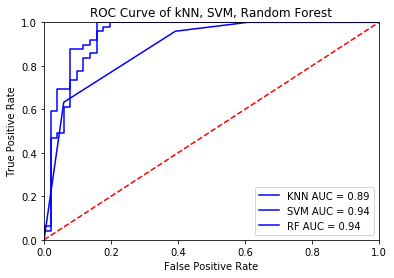

In [143]:
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
final_knn_classifier.fit(X, document_labels)
knn_y_scores = final_knn_classifier.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, threshold = roc_curve(test_labels, knn_y_scores)
knn_roc_auc = auc(knn_fpr,knn_tpr)

final_clf_svm = svm.SVC(kernel='rbf', gamma='scale', C=best_c)
final_clf_svm.fit(X, document_labels)
svm_y_scores = final_clf_svm.decision_function(X_test)
svm_fpr, svm_tpr, threshold = roc_curve(test_labels, svm_y_scores)
svm_roc_auc = auc(svm_fpr,svm_tpr)

final_rf_classifier = RandomForestClassifier(n_estimators=best_hyperparam_setting[0],
                                             max_depth=best_hyperparam_setting[1],
                                             random_state=0)
final_rf_classifier.fit(X, document_labels)
rf_y_scores = final_rf_classifier.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, threshold = roc_curve(test_labels, rf_y_scores)
rf_roc_auc = auc(rf_fpr,rf_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(knn_fpr, knn_tpr, 'b', label = 'KNN AUC = %0.2f' % knn_roc_auc)
plt.plot(svm_fpr, svm_tpr, 'b', label = 'SVM AUC = %0.2f' % svm_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'b', label = 'RF AUC = %0.2f' % rf_roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN, SVM, Random Forest')
plt.show()

Area Under SVM Curve: 0.91
Area Under kNN Curve: 0.89
Area Under RF Curve: 0.91


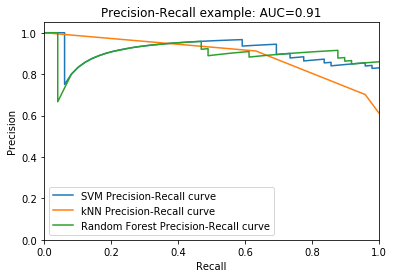

In [152]:
from sklearn.metrics import precision_recall_curve
import pylab as pl

# Compute Precision-Recall and plot curve svm
svm_precision, svm_recall, svm_threshold = precision_recall_curve(test_labels, svm_y_scores)
svm_area = auc(svm_recall, svm_precision)
print("Area Under SVM Curve: %0.2f" % svm_area)


# Compute Precision-Recall and plot curve kNN
knn_precision, knn_recall, knn_threshold = precision_recall_curve(test_labels, knn_y_scores)
knn_area = auc(knn_recall, knn_precision)
print("Area Under kNN Curve: %0.2f" % knn_area)

# Compute Precision-Recall and plot curve RandomForest
rf_precision, rf_recall, rf_threshold = precision_recall_curve(test_labels, rf_y_scores)
rf_area = auc(rf_recall, rf_precision)
print("Area Under RF Curve: %0.2f" % area)


pl.clf()
pl.plot(svm_recall, svm_precision, label='SVM Precision-Recall curve')
pl.plot(knn_recall, knn_precision, label='kNN Precision-Recall curve')
pl.plot(rf_recall, rf_precision, label='Random Forest Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])
pl.title('Precision-Recall example: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()

Of the ROC and Precision-Recall curves, which one would you use for this task and why?
Which classifier is the best, according to your chosen curves?

For this task I would use a Precision-Recall curve since the dataset is imbalanced. We are more interested in the correct prediciton of the minority class.

# Part 2: Representation Learning 

In [434]:
from tensorflow.python import keras
from keras.datasets import fashion_mnist
from keras.models import load_model
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Data exploration



x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


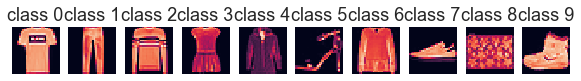

In [472]:
# load the MNIST data set, which already splits into train and test sets for us
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
_, x_img, y_img = x_train.shape
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
indexes=[]
# See how the images look like
labels = np.unique(y_train)
f, axarr = plt.subplots(1, 10, figsize=(10, 10))
for l in labels:
    idx = np.argwhere(y_train==l)[0][0]
    img = x_train[idx]
    axarr[l].imshow(img)
    axarr[l].set_title('class '+str(l))
    axarr[l].axis('off')


### Loading pre-trained CNN



In [473]:
num_classes = 10

# reshape the data into a 4D tensor: (sample_number, x_img_size, y_img_size, num_channels)
# because the fashion MNIST is greyscale, we only have a single channel
x_train = x_train.reshape(x_train.shape[0], x_img, y_img, 1)
x_test = x_test.reshape(x_test.shape[0], x_img, y_img, 1)

# convert the data to the right type
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)
# convert class vectors to binary class matrices - 
# this should be used for Keras functions
y_train_c = keras.utils.to_categorical(y_train, num_classes)
y_test_c = keras.utils.to_categorical(y_test, num_classes)

(60000, 28, 28, 1)


### (a) Data preprocessing


In [474]:

#create a list of labels to check for
element = [2,6]
#create boolean array using the label list
mask_train = np.isin(y_train, element)
mask_test = np.isin(y_test, element)
#use mask to get arrays with only 2s and 6s data 
x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]
y_train_c = y_train_c[mask_train]
y_test_c = y_test_c[mask_test]

In [475]:
print(x_train.shape, y_train.shape, y_train_c.shape)
print(x_test.shape, y_test.shape, y_test_c.shape)

(12000, 28, 28, 1) (12000,) (12000, 10)
(2000, 28, 28, 1) (2000,) (2000, 10)


In [476]:
import random
indices = random.sample(range(len(y_train)), 100)
x_train = x_train[indices]
y_train = y_train[indices]

### (b) Working with a pretrained convnet

In [477]:
# load the pre-trained CNN
model = load_model('./cnn_model.h5')
print('<Summary of the pre-trained CNN>')
model.summary()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
print('<Summary of the pre-trained CNN up to the bottleneck layer>')
intermediate_layer_model.summary()

<Summary of the pre-trained CNN>
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               460900    
_________________________________________________________________
bottleneck (Dense)           (None, 20)                2020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 463,962
Trainable params: 463,962
Non-trainable params: 0
______________

C:\Users\Molly\Anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [478]:
intermediate_output_train = intermediate_layer_model.predict(x_train)
intermediate_output_test = intermediate_layer_model.predict(x_test)

print('The bottleneck vector shape for training data is ',intermediate_output_train.shape)
print('The bottleneck vector shape for testing data is ',intermediate_output_test.shape)

The bottleneck vector shape for training data is  (100, 20)
The bottleneck vector shape for testing data is  (2000, 20)


In [479]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1,random_state=0, perplexity=40)
tsne_bottleneck = tsne.fit_transform(intermediate_output_test)
flattened_test_images = x_test.reshape(len(x_test), -1)  # flattens out each test image
flattened_test_images = flattened_test_images.astype(np.float32)/255
tsne_raw_features = tsne.fit_transform(flattened_test_images)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.713100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.702354
[t-SNE] KL divergence after 1000 iterations: 1.174927
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.060s...
[t-SNE] Computed neighbors for 2000 samples in 5.772s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.007525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.466187
[t-SNE] KL divergence after 1000 iterations: 1.261076


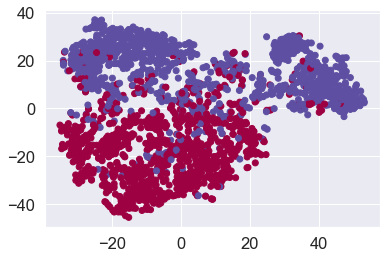

In [480]:
#scatter plot for 20 dimensional bottleneck features
plt.scatter(tsne_bottleneck[:, 0], tsne_bottleneck[:, 1],
            c=y_test, cmap='Spectral')


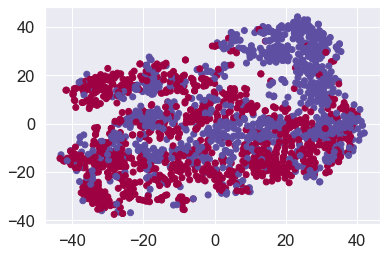

In [481]:
#scatter plot for raw features
plt.scatter(tsne_raw_features[:, 0], tsne_raw_features[:, 1],
            c=y_test, cmap='Spectral')

### (c) Test accuracy comparison



In [496]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from numpy import argmax

flattened_train_images = x_train.reshape(len(x_train), -1)  # flattens out each test image
flattened_train_images = flattened_train_images.astype(np.float32)/255

final_knn_classifier = KNeighborsClassifier(n_neighbors=1)
final_knn_classifier.fit(intermediate_output_train, y_train)
knn_y_scores = final_knn_classifier.predict(intermediate_output_test)
print("The bottleneck 1-NN accuracy score is",accuracy_score(y_test,knn_y_scores))

final_knn_classifier_raw = KNeighborsClassifier(n_neighbors=1)
final_knn_classifier_raw.fit(flattened_train_images, y_train)
knn_y_scores_raw = final_knn_classifier_raw.predict(flattened_test_images)
print("The raw features 1-NN accuracy score is", accuracy_score(y_test,knn_y_scores_raw))

final_clf_svm = svm.LinearSVC()
final_clf_svm.fit(intermediate_output_train, y_train)
ypred_svm_bot = final_clf_svm.predict(intermediate_output_test)
print("The bottleneck Linear SVM accuracy score is",accuracy_score(y_test,ypred_svm_bot))

final_clf_svm = svm.LinearSVC()
final_clf_svm.fit(flattened_train_images, y_train)
ypred_svm_raw = final_clf_svm.predict(flattened_test_images)
print("The raw features Linear SVM accuracy score is", accuracy_score(y_test,ypred_svm_raw))

final_rf_classifier = RandomForestClassifier(n_estimators=10)#default is 10, manually specified to make future warning go away
final_rf_classifier.fit(intermediate_output_train, y_train)
rf_y_scores_bot = final_rf_classifier.predict(intermediate_output_test)
print("The bottleneck features RandomForest accuracy score is", accuracy_score(y_test,rf_y_scores_bot))

final_rf_classifier = RandomForestClassifier(n_estimators=10)#default is 10, manually specified to make future warning go away
final_rf_classifier.fit(flattened_train_images, y_train)
rf_y_scores_raw = final_rf_classifier.predict(flattened_test_images)
print("The raw features RandomForest accuracy score is", accuracy_score(y_test,rf_y_scores_raw))


test_loss, test_acc = model.evaluate(x_test, y_test_c)
print('Test accuracy:', test_acc)

The bottleneck 1-NN accuracy score is 0.8805
The raw features 1-NN accuracy score is 0.74
The bottleneck Linear SVM accuracy score is 0.8935
The raw features Linear SVM accuracy score is 0.5
The bottleneck features RandomForest accuracy score is 0.826
The raw features RandomForest accuracy score is 0.7875
1344/2000 [===================>..........] - ETA: 

C:\Users\Molly\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2000/2000 [==============================] - 0s 75us/step
Test accuracy: 0.7674999833106995


Among the seven models above the model that performed the best is the Random Forest model with the raw features. The model that showed the lowest accuracy was the Linear SVM with raw features. On average the bottlenecked features performed better. 

### (d) ROC curve with varying k in k-NN


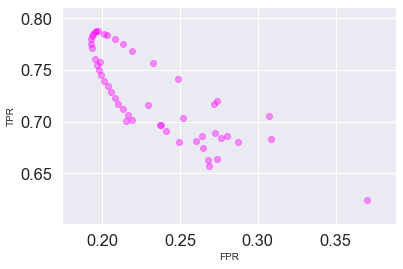

0.1926842105263158


In [484]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
#recall score = TPR
fpr_data=[]
tpr_data=[]

for k in range(1, 51):
    fpr=None
    tpr= None
    final_knn_classifier = KNeighborsClassifier(n_neighbors=k)
    final_knn_classifier.fit(intermediate_output_train, y_train)
    knn_y_scores = final_knn_classifier.predict_proba(intermediate_output_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, knn_y_scores, pos_label=6)
    fpr_data.append(np.mean(fpr))
    tpr_data.append(np.mean(tpr))

plt.scatter(fpr_data, tpr_data,c='magenta', alpha = 0.4)
plt.xlabel("FPR", fontsize=10)
plt.ylabel("TPR", fontsize=10)
plt.show()

lowest_fpr = np.amin(fpr_data)
print(lowest_fpr)

We would do something similar to the same above.We need to check multiple different k values and see how it runs on the data.As we see above, using the bottlenecked data helps to increase the accuracy of the model. We can use the ROC curve to see what the false positive rate is to choose the correct k value to use if they care about TPR and FPR.

# Part 3: Sentiment Analysis


In [3]:
import csv
import numpy as np

data_path = './HW3-data/train.csv'

import pandas as pd
df=pd.read_csv(data_path, sep=',',header=None,encoding='iso8859')

In [4]:
#read in test data
data_path2 = './HW3-data/test.csv'

import pandas as pd
df2=pd.read_csv(data_path2, sep=',',header=None,encoding='iso8859')
#drop unwanted columns
df2 = df2.drop(df2.columns[[1,2,3,4]], axis=1) 

In [5]:
#drop unwanted columns
len(df.columns)
df = df.drop(df.columns[[1,2,3,4]], axis=1) 

In [6]:
#create test data 
tweet_test=[]
y_test=[]
print(len(df2[0]))
for r in range(len(df2[0])):
    t=[]
    t = df2.iloc[r,1]
    y = df2.iloc[r,0]
    y_test.append(y)
    tweet_test.append(t)
y_test = np.array(y_test)

498


In [7]:
#shuffle training data
from sklearn.utils import shuffle
df = shuffle(df)
print(df.iloc[:5,:])
df.iloc[:,0].value_counts()

         0                                                  5
289670   0  I HATE being allergic to tomatoes....this so s...
702407   0  FOUND EM!!! on a day I have to work, the sun i...
793213   0  Getting ready 4 tonight.. Im tired now dammit ...
875122   1  @AlanDarcy What's up with the super long numbe...
1070607  1  @LeX_HeadBanga The weather is horrible...We ne...


1    800000
0    800000
Name: 0, dtype: int64

### (b) Data Preparation 

In [8]:
#training data preparation
tweet=[]
tweet_train=[]
for r in range(0,5000):
    t=[]
    t = df.iloc[r,1]
    y = df.iloc[r,0]
    tweet_train.append(y)
    tweet.append(t)
tweet_train = np.array(tweet_train)

In [9]:

from tensorflow.python.client import device_lib

from keras.preprocessing.text import Tokenizer

vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(tweet)
tweet = tokenizer.texts_to_sequences(tweet)

In [31]:
print(len(tweet))

5000


In [10]:
tweet_test = tokenizer.texts_to_sequences(tweet_test)

In [11]:
from keras.preprocessing.sequence import pad_sequences

tweet = pad_sequences(tweet, maxlen= 120, padding = 'post') 
tweet=np.array(tweet)

In [12]:
tweet_test = pad_sequences(tweet_test, maxlen= 120, padding = 'post') 
tweet_test=np.array(tweet_test)

###  (c) Simple RNN 

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=vocabulary_size, input_length = 120, output_dim=64))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(64))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.models import Model
from tensorflow.python import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM

In [18]:
results = model.fit(tweet, tweet_train, 
                    batch_size=32, 
                    epochs=5,
                    validation_split=0.2)


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 12s 3ms/sample - loss: 0.7016 - acc: 0.4997 - val_loss: 0.7072 - val_acc: 0.4690
Epoch 2/5
4000/4000 [==============================] - 11s 3ms/sample - loss: 0.6988 - acc: 0.5010 - val_loss: 0.6946 - val_acc: 0.4970
Epoch 3/5
4000/4000 [==============================] - 11s 3ms/sample - loss: 0.6952 - acc: 0.5085 - val_loss: 0.6958 - val_acc: 0.5120
Epoch 4/5
4000/4000 [==============================] - 12s 3ms/sample - loss: 0.6965 - acc: 0.5110 - val_loss: 0.6935 - val_acc: 0.5040
Epoch 5/5
4000/4000 [==============================] - 11s 3ms/sample - loss: 0.7006 - acc: 0.4970 - val_loss: 0.6973 - val_acc: 0.4760


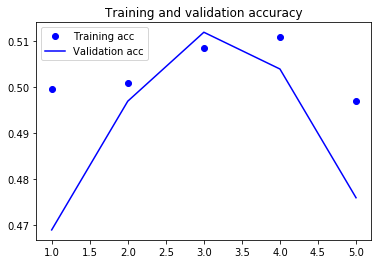

In [19]:


acc=results.history['acc']
val_acc=results.history['val_acc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### (d) LSTM

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model2 = tf.keras.Sequential()
model2.add(layers.Embedding(input_dim=vocabulary_size, input_length = 120, output_dim=64))

model2.add(layers.LSTM(64))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 16s 4ms/sample - loss: 0.6940 - acc: 0.4825 - val_loss: 0.6933 - val_acc: 0.4720
Epoch 2/5
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 3/5
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.6933 - acc: 0.5060 - val_loss: 0.6935 - val_acc: 0.4720
Epoch 4/5
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6941 - val_acc: 0.4720
Epoch 5/5
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.6933 - acc: 0.5060 - val_loss: 0.6931 - val_acc: 0.5280


<function matplotlib.pyplot.show(*args, **kw)>

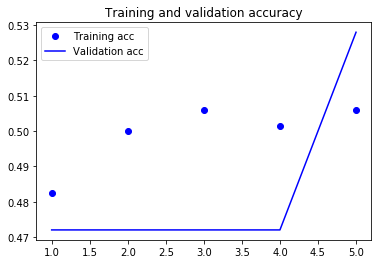

In [23]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

results2 = model2.fit(tweet, tweet_train, 
                    batch_size=64, 
                    epochs=5,
                    validation_split=0.2)

acc=results2.history['acc']
val_acc=results2.history['val_acc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show

### (e) Evaluation on test data

In [24]:
test_loss, test_acc = model.evaluate(tweet_test,y_test)
print('Test accuracy:', test_acc)


498/498 [==============================] - 1s 1ms/sample - loss: 0.7051 - acc: 0.3876
Test accuracy: 0.3875502


In [25]:
test_loss, test_acc = model2.evaluate(tweet_test,y_test)
print('Test accuracy:', test_acc)

498/498 [==============================] - 1s 3ms/sample - loss: 0.6931 - acc: 0.6345
Test accuracy: 0.6345382


The raw accuracy for the SimpleRNN model is 54.21% and the accuracy for the LSTM model is 63.45%.